## Neural ODE

### Imports

In [3]:
from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# device = torch.device("cuda")
device = torch.device("cpu")

### Data

In [ ]:
data = pd.read_csv("datas/data_3.csv")

t = torch.tensor(data['t'])
angular_velocity_data = data['angular_velocity']
angular_displacement_data = data['angular_displacement']

true_dxdt = torch.tensor(list([[x, y]] for x, y in zip(angular_displacement_data, angular_velocity_data)))

starting_point = true_dxdt[0]

print("> Starting point = {}".format(starting_point.squeeze()))
print("> t.shape = {}".format(t.shape))
print("> true_dxdt.shape = {}".format(true_dxdt.shape))

### Simulation Data

In [ ]:
x_m = 3.0 
b = 15.0  
m = 10.0  
k = 500.0 

def x_t(t, x_m, b, m, k):
    exp_term = torch.exp(-b / (2 * m) * t)
    sqrt_term = torch.sqrt(torch.tensor(k / m) - torch.tensor(b**2) / (4 * torch.tensor(m**2)))
    cos_term = torch.cos(sqrt_term * t)
    return x_m * exp_term * cos_term

def v_t(t, x_m, b, m, k):
    exp_term = torch.exp(-b / (2 * m) * t)
    sqrt_term = torch.sqrt(torch.tensor(k / m) - torch.tensor(b**2) / (4 * torch.tensor(m**2)))
    cos_term = torch.cos(sqrt_term * t)
    sin_term = torch.sin(sqrt_term * t)
    
    v = -x_m * exp_term * ((b / (2 * m)) * cos_term + sqrt_term * sin_term)
    return v

t_values = torch.linspace(0, 5, 1000)  

x_values = x_t(t_values, x_m, b, m, k)
v_values = v_t(t_values, x_m, b, m, k)

simulation_data = torch.tensor(list([[x, y]] for x, y in zip(x_values, v_values)))

print(simulation_data)
print(len(simulation_data))
print(simulation_data.shape)

true_dxdt = simulation_data
t = t_values
starting_point = true_dxdt[0]

tensor([[[ 3.0000, -2.2500]],

        [[ 2.9869, -2.9796]],

        [[ 2.9702, -3.6999]],

        ...,

        [[-0.0614,  0.2979]],

        [[-0.0599,  0.3108]],

        [[-0.0583,  0.3232]]])
1000
torch.Size([1000, 1, 2])


In [5]:
w = 50 ** 0.5

def x_t(t, x_m, w):
    return x_m * torch.cos(w * t)

def v_t(t, x_m, w):
    return -1 * x_m * w * torch.sin(w * t)

x_values = x_t(t_values, x_m, w)
v_values = v_t(t_values, x_m, w)

perfect_data = torch.tensor(list([[x, y]] for x, y in zip(x_values, v_values)))

print(perfect_data[:10])
print(len(perfect_data))
print(perfect_data.shape)

tensor([[[ 3.0000, -0.0000]],

        [[ 2.9981, -0.7506]],

        [[ 2.9925, -1.5002]],

        [[ 2.9831, -2.2480]],

        [[ 2.9700, -2.9930]],

        [[ 2.9532, -3.7342]],

        [[ 2.9326, -4.4707]],

        [[ 2.9084, -5.2017]],

        [[ 2.8806, -5.9261]],

        [[ 2.8491, -6.6431]]])
1000
torch.Size([1000, 1, 2])


### Batch Function

In [3]:
batch_size = 100
time_interval = 10

def get_batch():
    random_points = np.random.choice(np.arange(len(true_dxdt) - time_interval, dtype=np.int64), batch_size, replace=False)
    batch_starting_point = true_dxdt[random_points]
    batch_t = t[:time_interval]
    batch_dxdt = torch.stack([true_dxdt[random_points + i] for i in range(time_interval)], dim=0)

    return batch_starting_point, batch_t, batch_dxdt

### Neural Network

In [4]:
class PredictFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, t, x):
        return self.net(x)

### Visualization
Visualizes the trajectory of angular displacement and velocity over time, Phase Space, and learned Vector Field

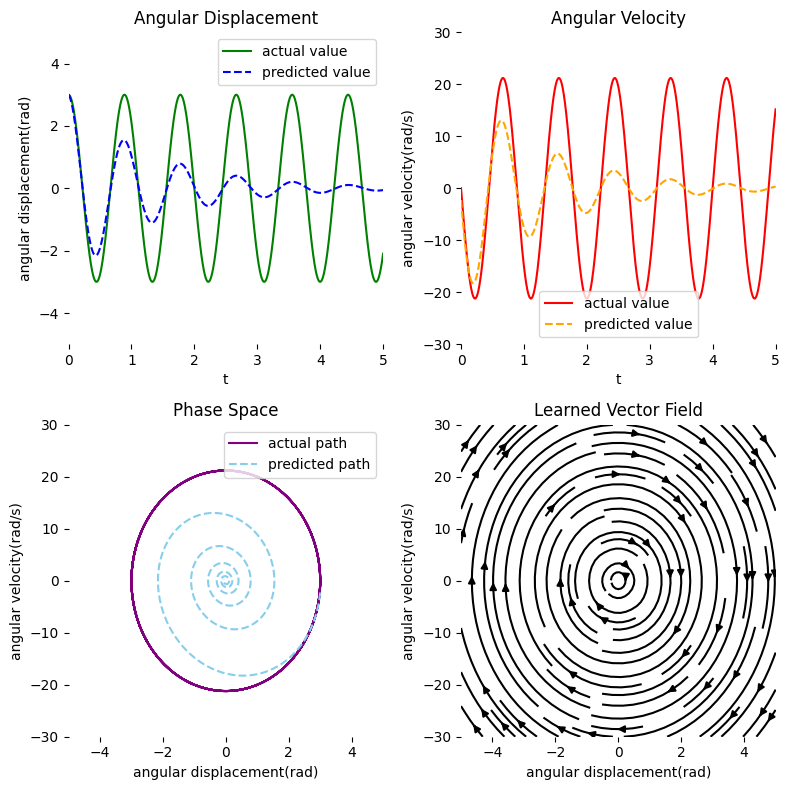

In [ ]:
max_angular_displacement = 5
max_angular_velocity = 30
vector_points = 20

def visualize(true_y, pred_y, odefunc, itr):
    fig = plt.figure(figsize=(8, 8), facecolor='white')

    angular_displacement = fig.add_subplot(221, frameon=False)
    angular_velocity = fig.add_subplot(222, frameon=False)
    phase_space = fig.add_subplot(223, frameon=False)
    vector_field = fig.add_subplot(224, frameon=False)

    angular_displacement.cla()
    angular_displacement.set_title('Angular Displacement')
    angular_displacement.set_xlabel('t')
    angular_displacement.set_ylabel('angular displacement(rad)')
    angular_displacement.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], color='green', linestyle='-', label='actual value')
    angular_displacement.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], color='blue', linestyle='--', label='predicted value')
    angular_displacement.set_xlim(t.cpu().min(), t.cpu().max())
    angular_displacement.set_ylim(-max_angular_displacement, max_angular_displacement)
    angular_displacement.legend(loc="best")

    angular_velocity.cla()
    angular_velocity.set_title('Angular Velocity')
    angular_velocity.set_xlabel('t')
    angular_velocity.set_ylabel('angular velocity(rad/s)')
    angular_velocity.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], color='red', linestyle='-', label='actual value')
    angular_velocity.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], color='orange', linestyle='--', label='predicted value')
    angular_velocity.set_xlim(t.cpu().min(), t.cpu().max())
    angular_velocity.set_ylim(-max_angular_velocity, max_angular_velocity)
    angular_velocity.legend(loc="best")

    phase_space.cla()
    phase_space.set_title('Phase Space')
    phase_space.set_xlabel('angular displacement(rad)')
    phase_space.set_ylabel('angular velocity(rad/s)')
    phase_space.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], color='purple', linestyle='-', label='actual path')
    phase_space.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], color='skyblue', linestyle='--', label='predicted path')
    phase_space.set_xlim(-max_angular_displacement, max_angular_displacement)
    phase_space.set_ylim(-max_angular_velocity, max_angular_velocity)
    phase_space.legend(loc="best")

    vector_field.cla()
    vector_field.set_title('Learned Vector Field')
    vector_field.set_xlabel('angular displacement(rad)')
    vector_field.set_ylabel('angular velocity(rad/s)')

    y, x = np.mgrid[-max_angular_velocity:max_angular_velocity:complex(vector_points), 
                    -max_angular_displacement:max_angular_displacement:complex(vector_points)]
    velocity = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(vector_points * vector_points, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(velocity[:, 0]**2 + velocity[:, 1]**2).reshape(-1, 1)
    velocity = (velocity / mag)
    velocity = velocity.reshape(vector_points, vector_points, 2)

    vector_field.streamplot(x, y, velocity[:, :, 0], velocity[:, :, 1], color="black")
    vector_field.set_xlim(-max_angular_displacement, max_angular_displacement)
    vector_field.set_ylim(-max_angular_velocity, max_angular_velocity)

    fig.tight_layout()
    plt.savefig('png/{:03d}.png'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    
class TargetFunction(nn.Module):
    def __init__(self, omega_x, omega_y):
        super().__init__()
        self.elliptic_matrix = torch.tensor([[0, -omega_y], [omega_x, 0]]).to(device)

    def forward(self, t, x):
        return torch.mm(x, self.elliptic_matrix)


omega_x = 0.2 
omega_y = 10  

elliptic_function = TargetFunction(omega_x, omega_y).to(device)

visualize(perfect_data, simulation_data, elliptic_function, 1)

### Learn

In [ ]:
os.makedirs("png", exist_ok=True)

history = []
epochs = 3000

net = PredictFunction().to(device)
opt = optim.Adam(net.parameters(), lr=3e-4)

for i in range(epochs+1):
    opt.zero_grad()
    batch_starting, batch_t, batch_dxdt = get_batch()
    pred_dxdt = odeint(net, batch_starting, batch_t).to(device)
    loss = F.l1_loss(pred_dxdt, batch_dxdt)
    loss.backward()
    opt.step()
    print(f"\r> [{i}/{epochs}] loss = {round(loss.item(), 3)}", end='')
    history.append(loss.item())

    if i % 300 == 0:
        with torch.no_grad():
            pred_dxdt = odeint(net, starting_point, t)
            visualize(true_dxdt, pred_dxdt, net, i)
        print("")

### Learning Curve

In [ ]:
# history = np.random.random(100)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(history)), history, linestyle='-', color='orange', label='Learning Curve')  

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
torch.save(net.state_dict(), 'model_state_dict.pt')
loaded_model = PredictFunction()
loaded_model.load_state_dict(torch.load('model_state_dict.pt'))

### Boid

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# scale = 1
# # Boids parameters
# time_steps = 500
# num_boids = 100 * scale
# width, height = 100 * scale, 100 * scale  # Dimensions of the simulation space
# max_speed = 2.0 * scale
# neighborhood_radius = 10.0 * scale
# separation_distance = 2.0 * scale
# alignment_weight = 0.1 * scale
# cohesion_weight = 0.01 * scale
# separation_weight = 0.1 * scale

# # Initialize boids with random positions and velocities
# positions = (np.random.rand(num_boids, 2) - 0.5) * [width, height]
# velocities = (np.random.rand(num_boids, 2) - 0.5) * max_speed

# # Function to update velocities and positions of all boids
# def update_boids(positions, velocities):
#     new_velocities = np.copy(velocities)
#     for i, (pos, vel) in enumerate(zip(positions, velocities)):
#         # Find neighbors
#         distances = np.linalg.norm(positions - pos, axis=1)
#         neighbors = (distances > 0) & (distances < neighborhood_radius)
        
#         if np.any(neighbors):
#             # Separation
#             separation_vector = np.sum(pos - positions[neighbors], axis=0)
#             separation_force = separation_weight * separation_vector

#             # Alignment
#             average_velocity = np.mean(velocities[neighbors], axis=0)
#             alignment_force = alignment_weight * (average_velocity - vel)
            
#             # Cohesion
#             center_of_mass = np.mean(positions[neighbors], axis=0)
#             cohesion_vector = center_of_mass - pos
#             cohesion_force = cohesion_weight * cohesion_vector

#             # Update velocity
#             new_velocities[i] += separation_force + alignment_force + cohesion_force
        
#         # Limit the speed
#         speed = np.linalg.norm(new_velocities[i])
#         if speed > max_speed:
#             new_velocities[i] = (new_velocities[i] / speed) * max_speed

#     # Update positions
#     new_positions = positions + new_velocities

#     # Ensure positions stay within bounds (-50 to 50 for both axes)
#     new_positions[:, 0] = np.clip(new_positions[:, 0], -width/2, width/2)
#     new_positions[:, 1] = np.clip(new_positions[:, 1], -height/2, height/2)
    
#     return new_positions, new_velocities

# # Run simulation and collect data for a single boid
# tracked_boid_index = 0
# tracked_boid_positions = []
# com_positions = []

# for t in range(time_steps):
#     positions, velocities = update_boids(positions, velocities)
#     tracked_boid_positions.append(positions[tracked_boid_index])
#     com_positions.append(np.mean(positions, axis=0))
# # Convert to numpy arrays for easier handling
# tracked_boid_positions = np.array(tracked_boid_positions)
# com_positions = np.array(com_positions)


# com_scaling_factor = 10

# # Plotting the tracked boid's path and COM's path
# plt.figure(figsize=(8, 8))
# plt.plot(tracked_boid_positions[:, 0], tracked_boid_positions[:, 1], marker='o', markersize=3, linestyle='', label='Tracked Boid')
# plt.plot(com_positions[:, 0] * com_scaling_factor, com_positions[:, 1] * com_scaling_factor, marker='x', linestyle='-', label=f'Center of Mass (magnified by: {com_scaling_factor}x)', color='red')
# plt.title("Trajectory of a Single Boid and Center of Mass (COM) in a Flock")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.xlim(-width / 2, width / 2)
# plt.ylim(-height / 2, height / 2)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.grid(True)
# plt.legend()
# plt.show()
